# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle
import pathlib 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sys.path.append(str(Path('.').absolute()))
from NLMixedUtils.utils import *
import NLMixedUtils.io_dict_to_hdf5 as ioh5
from NLMixedUtils.format_data import *
from NLMixedUtils.models import *
from NLMixedScripts.fit_GLM import *
# pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:6379',
 'object_store_address': '/tmp/ray/session_2022-04-06_08-33-55_198358_526863/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-04-06_08-33-55_198358_526863/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-04-06_08-33-55_198358_526863',
 'metrics_export_port': 65085,
 'node_id': '7128bb3d179dff7206832c52cc6c77a3366081b5688278fd99adae56'}

tsp python fit_GLM.py --date_ani='070921/J553RT' --ModRun=-1 --Nepochs=10000 --do_shuffle=False --NoShifter=False --complex=True
tsp python fit_GLM.py --date_ani='101521/J559NC' --ModRun=-1,0,1,2,3,4 --Nepochs=10000 --do_shuffle=False --NoShifter=False --complex=True
tsp python fit_GLM.py --date_ani='102821/J570LT' --ModRun=-1,0,1,2,3,4 --Nepochs=10000 --do_shuffle=False --NoShifter=False --complex=True
tsp python fit_GLM.py --date_ani='110421/J569LT' --ModRun=-1,0,1,2,3,4 --Nepochs=10000 --do_shuffle=False --NoShifter=False --complex=True

tsp python fit_GLM.py --date_ani='122021/J581RT' --ModRun=2,3,4 --Nepochs=10000 --do_shuffle=False --NoShifter=False
tsp python fit_GLM.py --date_ani='020422/J577RT' --ModRun=2,3,4 --Nepochs=10000 --do_shuffle=False --NoShifter=False

tsp python fit_GLM.py --date_ani='121521/SimRF' --ModRun=1 --Nepochs=10000

tsp python format_data.py --date_ani='070921/J553RT'
tsp python format_data.py --date_ani='102821/J570LT'
tsp python format_data.py --date_ani='110421/J569LT'

In [2]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
args['train_shifter']=False
args['NoL1'] = False
args['do_shuffle']=False
args['Nepochs'] = 10000
args['complex'] = True
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))


Done Loading Unaligned data
Tot_units: (128,)
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: False


In [98]:
model_vid_sm_shift = ioh5.load(params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1))['model_vid_sm_shift']  # [:,5:-5,5:-5]
params['nks'] = np.shape(model_vid_sm_shift)[1:]
params['nk'] = params['nks'][0]*params['nks'][1]*params['nt_glm_lag']
rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in params['lag_list']])  
x_train = rolled_vid[train_idx].reshape(len(train_idx), -1).astype(np.float32)
x_test = rolled_vid[test_idx].reshape(len(test_idx), -1).astype(np.float32)
# x_train_p = x_train.copy()
# x_train_m = x_train.copy()
# x_test_p = x_test.copy()
# x_test_m = x_test.copy()
# x_train_p[x_train_p<0] = 0
# x_train_m[x_train_m>0] = 0
# x_test_p[x_test_p<0] = 0
# x_test_m[x_test_m>0] = 0
x_train = np.concatenate((x_train,x_train**2),axis=1)
x_test = np.concatenate((x_test,x_test**2),axis=1)
params['nk'] = x_train.shape[1]


(21191, 2400)

In [ ]:
np.where(data['unit_nums']==241)

(array([44]),)

# Load Paper Data

In [3]:
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'RevisionFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
move_clrs = ['blue','orange','green','red'] #["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
q_clrs = ["#f72585","#7209b7","#3f37c9","#4cc9f0"] # Magenta to Blue
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"] #["#003d36", "#a38d00", "#ff3b05", "#70a0ff"]#["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
# mod_clrs = ["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
fontsize=10
mod_titles = ['pos','vis','add','mul','HF']

import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "Arial",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'

                    })

In [4]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['do_shuffle']=False
    args['Nepochs'] = 10000
    args['complex'] = True
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
    else: 
        L1 = 'withL1'
    if args['complex']:
        L1 = L1 + '_complex2'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('Revisions_Testing' in path.as_posix()) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    model_move_FM.append(model_move)
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)
model_move_FM = np.concatenate(model_move_FM,axis=0)
model_move_HF = np.concatenate(model_move_HF,axis=0)


Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:660: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (67,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:660: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (56,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:660: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (71,)
Done Loading Unaligned data
Tot_units: (71,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:660: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [ ]:

sf=4
params['nt_glm_lag']=1
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun != 4):
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


In [6]:

sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun != 4):
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done Loading Unaligned data
Tot_units: (128,)


In [6]:
  
da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


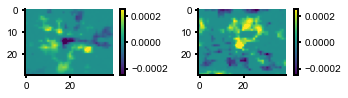

In [7]:
fig, axs = plt.subplots(1,2,figsize=(5,10))
ax = axs[0]
im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][0,0],vmin=-.00025,vmax=.00025)
add_colorbar(im)
ax = axs[1]
im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][0,5],vmin=-.00025,vmax=.00025)
add_colorbar(im)
plt.tight_layout()

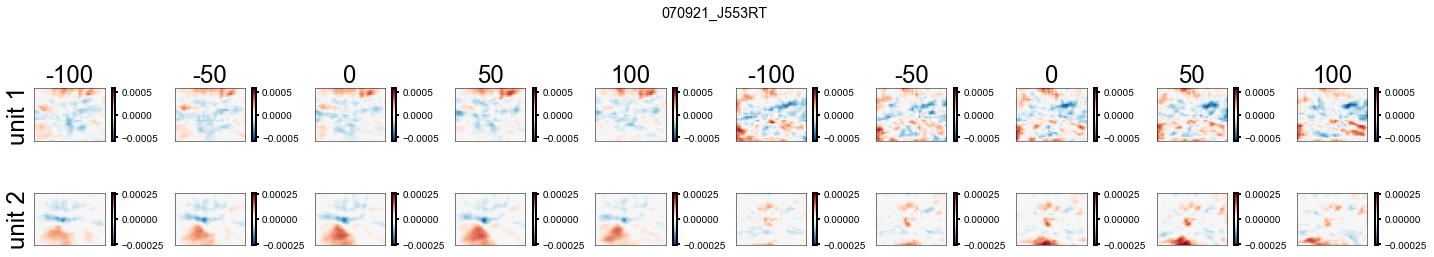

In [23]:
pdf_name = paper_fig_dir/ ('Complex_Cell_Summary.pdf')

# pdf = PdfPages(pdf_name)

lag_ls = [-100,-50,0,50,100,-100,-50,0,50,100] # ['Normal','Square']
lag_list = [-2,1,0,1,2,-2,1,0,1,2]
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [86,87] #np.arange(20) # np.arange(All_data[date_ani2[da]]['vis_rf_all'].shape[0]) #

fig1,axs1 = plt.subplots(len(cells),len(lag_list),figsize=(20,2*len(cells)))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_all'][cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][cell,m],'RdBu_r',vmin=-crange,vmax=crange)
        add_colorbar(im)
        axs1[0,m].set_title('{}'.format(lag_ls[m]),fontsize=fontsize)
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

# cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
# cbar2.set_ticks([-crange, crange])
# cbar2.set_ticklabels(['dark', 'light'])
# cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
# cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(date_ani2[da],y=1)
plt.tight_layout()
# pdf.savefig()
# plt.close()

# pdf.close()

In [8]:
All_data[date_ani2[da]]['vis_rf_all'].shape

(108, 10, 30, 40)

Text(0.5, 1.0, '0.364')

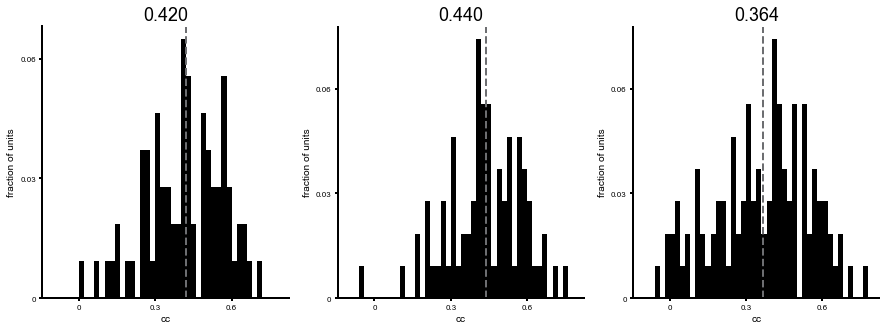

In [9]:
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all[:1]))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all[:1]))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all[:1]))])


fig, axs = plt.subplots(1,3, figsize=(15,5))
hbins = .02
lim0 = -.1
lim1 = .8
dlim = .2
xlab = 'cc'

ax = axs[0]
count,edges = np.histogram(vals_Vis,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Vis),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Vis),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Vis)))

ax = axs[1]
count,edges = np.histogram(vals_Add,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Add),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Add),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Add)))

ax = axs[2]
count,edges = np.histogram(vals_Mul,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Mul),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Mul)))
# fig.savefig(paper_fig_dir/'cc_hist.png')


## Full Figure CC Version

In [12]:
da = 1
args['free_move']=True
args['do_shuffle']=False
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (67,)


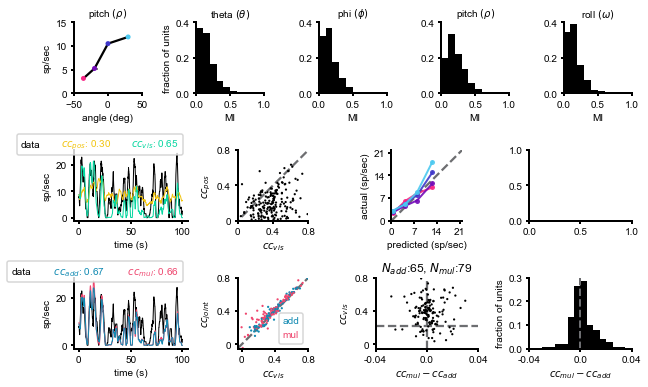

In [14]:
###### Fig 4 with CC

titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
celln = 52#
modN = 1
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs0a = np.array([fig.add_subplot(gs00[0,m]) for m in range(5)])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

modeln = 2
ax = axs0a[0]
metric = move_data[params['bin_length']:-params['bin_length'],modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

edge_mids = np.quantile(metric,spk_percentile2)#
# ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
ax.set_xlim(-xlim_range,xlim_range)
ax.set_ylim(0,15)
ax.set_xlabel('angle (deg)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.set_title(titles[modeln],fontsize=fontsize)

########## Fig 4B ########## 
##### Modulation Index Histograms #####
dwidth = .1
for modeln in np.arange(0,len(titles)):
    ax = axs0a[modeln+1]
    count,edges = np.histogram(tuning_sig_all[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(tuning_sig_all[:,modeln]),color='k',width=dwidth,alpha=1)
    ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
    ax.set_xlabel('MI', fontsize=fontsize)
    # ax.set_ylabel('fraction of units', fontsize=fontsize)
    ax.set_xlim(0,1)
    ax.set_yticks(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_yticklabels(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_ylim(0,.4)
axs0a[1].set_ylabel('fraction of units', fontsize=fontsize)

########## Fig 4C/G ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[1:,:1],wspace=.05,hspace=.8)
axs1a = np.array([fig.add_subplot(gs01[0,0])])
axs2a = np.array([fig.add_subplot(gs01[1,0])])

cmap = mpl.colors.ListedColormap(q_clrs)

celln = 52#106
da = 1
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
dt = int(100/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs1a[0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(0,2):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=1,
            label=r'$cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln]),zorder=zorder[modN])
legend1 = ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
# legend1.texts[1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)


##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2a[0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(2,len(mod_titles)-1):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=1,
            label=r' $cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln]),zorder=zorder[modN])
ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)



gs02 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs0[1:,1:],wspace=.5,hspace=.8)
axs3a = np.array([fig.add_subplot(gs02[n,m]) for n in range(2) for m in range(3)]).reshape(2,3)

########## Fig 4D ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])


tuning_idx = np.where(tuning_sig_all2)[0]
lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
##### Vis vs Mot #####
ax = axs3a[0,0]
im=ax.scatter(vals_Vis,vals_Mot,c='k',s=5,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{pos}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(0,.8)
ax.set_xlim(0,.8)



########## Fig 4E ########## 

ax = axs3a[0,1]
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts 
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    ax.plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=2,ms=10,alpha=.9,zorder=2,markeredgewidth=0)
    ax.set_xlabel('predicted (sp/sec)',fontsize=fontsize)
    ax.set_ylabel('actual (sp/sec)',fontsize=fontsize)

lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
lims = (-.05, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),c='#6D6E71',ls='--',zorder=0)
# ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
ax.set_xticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_yticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_xticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.set_yticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.axis('square')
ax.set(xlim=lims, ylim=lims)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)


########## Fig 4H ########## 

##### Vis vs Add/Mul #####
cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
vals_AM = np.nanmax(np.stack((vals_Add,vals_Mul)),axis=0)
AvM = vals_Add<vals_Mul
AvM_thresh = (~np.isnan(vals_Vis)) & (~np.isnan(vals_AM))
ax = axs3a[1,0]
scatter=ax.scatter(vals_Vis[AvM_thresh],vals_AM[AvM_thresh],s=5,c=AvM[AvM_thresh],cmap=cmap_mod,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{joint}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(-.05, .8)
ax.set_xlim(-.05, .8)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),fontsize=fontsize,markerscale=0, handlelength=0, handletextpad=0,loc="lower right")
legend1.get_texts()[0].set_text('add')
legend1.get_texts()[0].set_color(mod_clrs[2])
legend1.get_texts()[1].set_text('mul')
legend1.get_texts()[1].set_color(mod_clrs[3])

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]


##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[1,1]
im = ax.scatter(diff[th],increase[th],s=5,c='k',edgecolors='none')
# im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_title(r'$N_{{add}}$:{}, $N_{{mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize+2)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.04,.04)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0)


##### Hist of Add-Mul #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) & (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]
ax=axs3a[1,2]
hbins=.005
count,edges = np.histogram(vals_Mul-vals_Add,bins=np.arange(-.05,.05,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.axvline(x=0,c='#6D6E71',ls='--',lw=2)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_xlim([-.04, .04])
ax.set_yticks([0,.1,.2,.3])

plt.show()
gs0.tight_layout(fig)

# fig.savefig(paper_fig_dir/'Fig4_draft_V4_Cell52_101521_cc.pdf', facecolor='white', transparent=True, bbox_inches='tight')


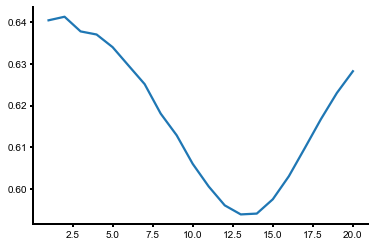

In [37]:
plt.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,101])
# plt.plot(np.mean(All_data[date_ani2[da]]['vis_loss_regcv'][0],axis=-1))

In [32]:
All_data[date_ani2[da]]['vis_loss_regcv'][0].shape

(21, 108)

## Single Comparison

In [11]:
da = 0
args['date_ani'] = dates_all[da]
args['free_move'] = True
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]


Done Loading Unaligned data
Tot_units: (128,)


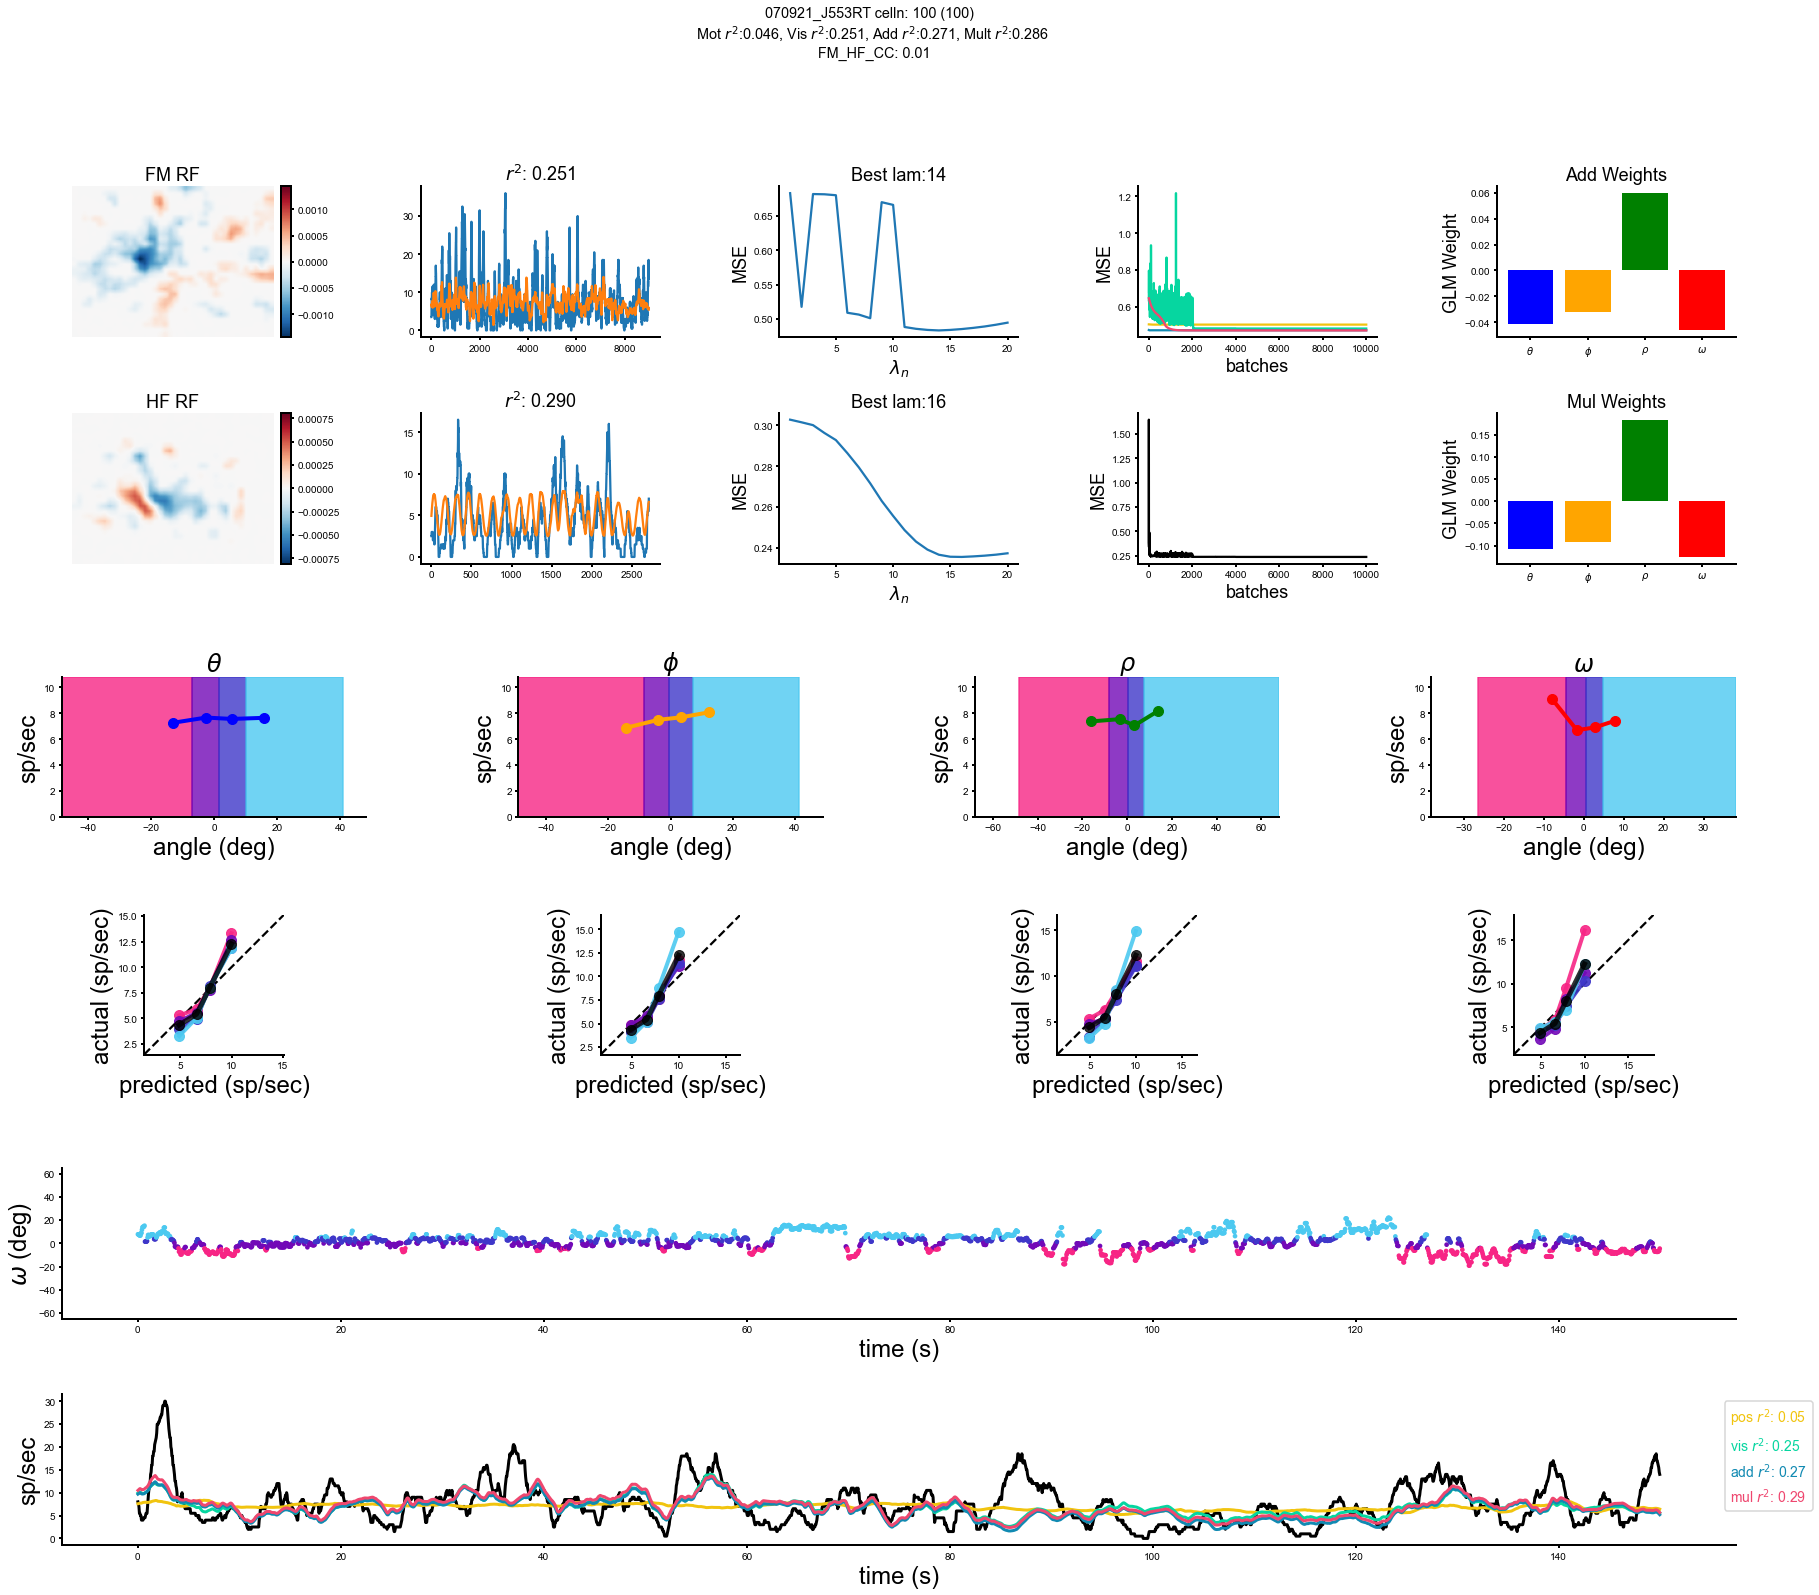

In [14]:
celln = 100
modN = 1
fontsize=24
anglim=65
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) 
fig = plt.figure(constrained_layout=False, figsize=(30,25))
gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

########## Plotting FM/HF RFs ##########
gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

ax = axs0a[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')
ax.set_title('FM RF')

ax = axs0a[1]
ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['vis_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['vis_r2_test'][celln]))

ax = axs0a[2]
ax.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])))

ax =axs0a[3]
for modN in range(len(mod_titles)-1):
    ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

########### Head Fixed plots ###########
ax = axs0b[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.set_title('HF RF')
ax.axis('off')

ax = axs0b[1]
ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['HF_r2_test'][celln]))

ax = axs0b[2]
ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

ax =axs0b[3]
ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

######### Position Weights ##########

w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
for modeln in range(len(titles)):
    axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
    axs0a[4].set_xticks(np.arange(0,len(titles)))
    axs0a[4].set_xticklabels(titles)
    axs0a[4].set_ylabel('GLM Weight')
    axs0a[4].set_title('Add Weights')

    axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
    axs0b[4].set_xticks(np.arange(0,len(titles)))
    axs0b[4].set_xticklabels(titles)
    axs0b[4].set_ylabel('GLM Weight')
    axs0b[4].set_title('Mul Weights')



########## Fig 4A ########## 
gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#
    for m in range(len(nranges)-1):
        axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
    axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
    axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
    axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
    axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

    
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts 
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].axis('square')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    # axs1b[0,modeln].axis('equal')
    axs1b[0,modeln].set(xlim=lims, ylim=lims)
    # axs1b[0,modeln].set_ylim(bottom=0)



########## Fig 4B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

cmap = mpl.colors.ListedColormap(q_clrs)
##### Plotting Position Scatter #####
t0=300
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-t0)) # 200 seconds in #6000
dt = int(150/params['model_dt']) # All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2[0,0]
metric = move_data[params['bin_length']:-params['bin_length'],3]
ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
ax.set_ylabel(r'$\omega$ (deg)',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylim([-anglim,anglim])

# celln = 18#106
# da = 0
# t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
# dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2b[0,0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
for modN in range(len(mod_titles)-1):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

Mot_r2 = All_data[date_ani2[da]]['pos_r2_test'][celln]
Vis_r2 = All_data[date_ani2[da]]['vis_r2_test'][celln]
Add_r2 = All_data[date_ani2[da]]['add_r2_test'][celln]
Mul_r2 = All_data[date_ani2[da]]['mul_r2_test'][celln]
FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_r2'][celln]
plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,celln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
plt.show()

In [15]:
ModelList

array([PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data2/070921/J553RT/fm1/Revisions_Testing/MovModel0/version_0/GLM_Pytorch_Mot_withL1_complex2_dt050_T05_MovModel0_NB10000_Kfold00_best.h5'),
       PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data2/070921/J553RT/fm1/Revisions_Testing/MovModel1/version_0/GLM_Pytorch_Vis_withL1_complex2_dt050_T05_MovModel1_NB10000_Kfold00_best.h5'),
       PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data2/070921/J553RT/fm1/Revisions_Testing/MovModel2/version_0/GLM_Pytorch_Add_withL1_complex2_dt050_T05_MovModel2_NB10000_Kfold00_best.h5'),
       PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data2/070921/J553RT/fm1/Revisions_Testing/MovModel3/version_0/GLM_Pytorch_Mul_withL1_complex2_dt050_T05_MovModel3_NB10000_Kfold00_best.h5'),
       PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data2/070921/J553RT/hf1_wn/Revisions_Testing/MovModel1/version_0/GLM_Pytorch_Vis_withL1_complex2_dt050_T05_MovModel1_NB10000_Kfold0

In [17]:
GLM_Data = ioh5.load(ModelList[1])
GLM_Data.keys()

dict_keys(['Cell_NN.0.bias', 'Cell_NN.0.weight', 'cc_test', 'loss_regcv', 'out_cv', 'pred_cv', 'r2_test', 'tloss_trace_all', 'vloss_trace_all'])

86

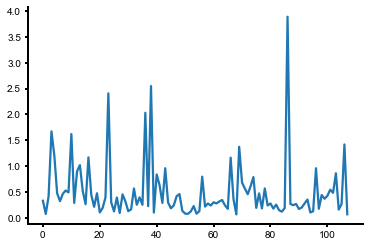

In [21]:
plt.plot(GLM_Data['tloss_trace_all'][:,-1])
np.argmax(GLM_Data['tloss_trace_all'][:,-1])

### Comparison of all Plots

In [15]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))


In [ ]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['Pos','Vis','Add','Mul','HF']
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all = [],[], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag'] = 5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(set(date_ani_dir.rglob(mod_name+'.h5')) - set(date_ani_dir.rglob('*VisNoShifter'+mod_name+'.h5')))))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)



Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [ ]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun == 4):
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)


In [16]:

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)


In [17]:
save_pdf = True
anglim = 65
fontsize=24
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'PaperFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
pdf_name = paper_fig_dir/ ('MoViAdMuHF_AllCells_CellSummary.pdf')
totcelln = 0
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig = plt.figure(constrained_layout=False, figsize=(30,10))
    gs0 = gridspec.GridSpec(nrows=2, ncols=5, figure=fig,wspace=.8,hspace=.3)

    ########## Histograms of R2 ##########
    axs0a = np.array([fig.add_subplot(gs0[0, n]) for n in range(gs0.ncols)])
    axs0b = np.array([fig.add_subplot(gs0[1, n]) for n in range(gs0.ncols)])

    vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_r2_test'] for da in range(len(dates_all))])
    vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
    vals_Add = np.hstack([All_data[date_ani2[da]]['add_r2_test'] for da in range(len(dates_all))])
    vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_r2_test'] for da in range(len(dates_all))])
    vals_HF  = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
    vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_r2']  for da in range(len(dates_all))])

    r2_all = np.stack((vals_Mot,vals_Vis,vals_Add,vals_Mul,vals_HF))
    hbins=.05
    for n in range(len(mod_titles)):
        ax = axs0a[n]
        count,edges = np.histogram(r2_all[n],bins=np.arange(0,1,hbins))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
        ax.set_xticks(np.arange(0,1.2,.2))
        ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
        ax.set_title(mod_titles[n])
        ax.set_xlabel(r'$r^2$')

    ax=axs0b[-1]
    count,edges = np.histogram(np.abs(vals_FMHF),bins=np.arange(0,1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
    ax.set_xticks(np.arange(0,1.2,.2))
    ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
    ax.set_title('FM_HF_CC')
    ax.set_xlabel('cc')
    ########## Scatter of all R2 ########## 

    tuning_idx = np.where(tuning_sig_all)[0]
    lims = (0, .65)
    crange=500
    ##### Vis vs Mot #####
    ax = axs0b[0]
    # im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[1],cmap='jet',s=20,vmin=-crange,vmax=crange)
    # ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    # ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    # ax.set_ylabel('Position: $r^2$',fontsize=fontsize)
    # ax.set_yticks(np.arange(0,lims[1],.2))
    # ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    # ax.set_ylim(0,lims[1])
    # ax.set_xlim(0,lims[1])
    # ax.set_xticks(np.arange(0,lims[1],.2))
    # ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    # ax.axis('equal')
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    ##### Vis vs Add/Mul #####
    cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
    vals_AM = np.max(np.stack((vals_Add,vals_Mul)),axis=0)
    AvM = vals_Add<vals_Mul
    ax = axs0b[1]
    scatter=ax.scatter(vals_Vis,vals_AM,30,c=AvM,cmap=cmap_mod)
    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    ax.set_ylabel('$r^2$',fontsize=fontsize)
    ax.set_yticks(np.arange(0,lims[1],.2))
    ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.set_ylim(0,lims[1])
    ax.set_xlim(0,lims[1])
    ax.set_xticks(np.arange(0,lims[1],.2))
    ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.axis('equal')
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),fontsize=14,markerscale=0, handlelength=0, handletextpad=0,loc="best")
    legend1.get_texts()[0].set_text('Add') 
    legend1.get_texts()[0].set_color(mod_clrs[2])
    legend1.get_texts()[1].set_text('Mul')
    legend1.get_texts()[1].set_color(mod_clrs[3])

    vloss_Mot = np.hstack([All_data[date_ani2[da]]['pos_vloss_trace'] for da in range(len(dates_all))])
    vloss_Vis = np.hstack([All_data[date_ani2[da]]['vis_vloss_trace'] for da in range(len(dates_all))])
    vloss_Add = np.hstack([All_data[date_ani2[da]]['add_vloss_trace'] for da in range(len(dates_all))])
    vloss_Mul = np.hstack([All_data[date_ani2[da]]['mul_vloss_trace'] for da in range(len(dates_all))])

    # ##### MSE #####
    # diff = vloss_Add-vloss_Mul
    # increase = 1-vloss_Vis
    # th = increase>-0

    # NMul = np.sum(diff[th]>0)
    # NAdd = np.sum(diff[th]<0)
    # ax=axs0b[2]
    # im=ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    # ax.axvline(x=0,c='k')
    # ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    # ax.set_xlabel('MSE: Add-Mul',fontsize=fontsize)
    # ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    # ax.set_ylim(-.05,.25)
    # ax.set_xlim(-.02,.02)
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    # ##### R2 Explained Variance #####
    # diff = vals_Mul-vals_Add
    # increase = 1-vloss_Vis
    # th = increase>-0

    # NMul = np.sum(diff[th]>0)
    # NAdd = np.sum(diff[th]<0)
    # ax=axs0b[3]
    # im = ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    # ax.axvline(x=0,c='k')
    # ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    # ax.set_xlabel('R2: Mul-Add',fontsize=fontsize)
    # ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    # ax.set_ylim(-.05,.25)
    # ax.set_xlim(-.075,.075)
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    plt.tight_layout()
    pdf.savefig()
    plt.close()
for da in tqdm(np.arange(len(date_ani2))):
    args['date_ani'] = dates_all[da]
    args['free_move'] = True
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    ncells=All_data[date_ani2[da]][mod_titles[0]+'_pred_smooth'].shape[-1]
    for celln in tqdm(np.arange(ncells)):
        predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
        nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
        pred_range = np.quantile(predcell,[.1,.9])
        test_nsp_range = np.quantile(nspcell,[.01,1])
        pred_rangelin = np.quantile(predcell,spike_percentiles)
        xbin_pts = np.quantile(predcell,spk_percentile2)
        stat_bins = len(pred_rangelin)
        fig = plt.figure(constrained_layout=False, figsize=(30,25))
        gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

        ########## Plotting FM/HF RFs ##########
        gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
        axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
        axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

        ax = axs0a[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')
        ax.set_title('FM RF')

        ax = axs0a[1]
        ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['vis_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_FM[celln]))

        ax = axs0a[2]
        ax.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])))

        ax =axs0a[3]
        for modN in range(len(mod_titles)-1):
            ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ########### Head Fixed plots ###########
        ax = axs0b[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.set_title('HF RF')
        ax.axis('off')

        ax = axs0b[1]
        ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_HF[celln]))

        ax = axs0b[2]
        ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

        ax =axs0b[3]
        ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ######### Position Weights ##########

        w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
        w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
        for modeln in range(len(titles)):
            axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
            axs0a[4].set_xticks(np.arange(0,len(titles)))
            axs0a[4].set_xticklabels(titles)
            axs0a[4].set_ylabel('GLM Weight')
            axs0a[4].set_title('Add Weights')

            axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
            axs0b[4].set_xticks(np.arange(0,len(titles)))
            axs0b[4].set_xticklabels(titles)
            axs0b[4].set_ylabel('GLM Weight')
            axs0b[4].set_title('Mul Weights')



        ########## Fig 4A ########## 
        gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
        axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
        axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

        top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
        traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
        edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        for i,modeln in enumerate(range(len(titles))):
            metric = move_data[params['bin_length']:-params['bin_length'],modeln]
            nranges = np.quantile(metric,quartiles)
            stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
            edge_mids = np.quantile(metric,spk_percentile2)#
            for m in range(len(nranges)-1):
                axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
            axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
            axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
            xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
            axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
            axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
            axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
            axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

            try:
                stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts 
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]
                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                    axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
                    axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
                
                lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
                lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
                lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
                axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                # axs1b[0,modeln].axis('equal')
                axs1b[0,modeln].set(xlim=lims, ylim=lims)
                # axs1b[0,modeln].set_ylim(bottom=0)
            except:
                print(celln, 'Failed')


        ########## Fig 4B ########## 
        gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
        axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
        axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

        cmap = mpl.colors.ListedColormap(q_clrs)
        ##### Plotting Position Scatter #####
        t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
        dt = int(200/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2[0,0]
        metric = move_data[params['bin_length']:-params['bin_length'],3]
        ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
        ax.set_ylabel(r'$\rho$ (deg)',fontsize=fontsize)
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylim([-anglim,anglim])

        # celln = 18#106
        # da = 0
        # t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
        # dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
        ##### Plotting Firing Rate #####
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2b[0,0]
        zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
        ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
        for modN in range(len(mod_titles)-1):
            ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
                    label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
        ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylabel('sp/sec',fontsize=fontsize)

        Mot_r2 = All_data[date_ani2[da]]['pos_r2_test'][celln]
        Vis_r2 = All_data[date_ani2[da]]['vis_r2_test'][celln]
        Add_r2 = All_data[date_ani2[da]]['add_r2_test'][celln]
        Mul_r2 = All_data[date_ani2[da]]['mul_r2_test'][celln]
        FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_r2'][celln]
        plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,totcelln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
        totcelln = totcelln+1
        # fig.savefig(paper_fig_dir/'Fig4_draft_Cell52_101521.png', facecolor='white', transparent=True, bbox_inches='tight')
        # plt.tight_layout()
        if save_pdf:
            pdf.savefig()
            plt.close()
if save_pdf:
    pdf.close()


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/colors.py:1159: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/ticker.py:633: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
/tmp/ipykernel_526863/1591633556.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  0%|          | 0/4 [00:00<?, ?it/s]

Done Loading Unaligned data
Tot_units: (128,)


  0%|          | 0/108 [00:00<?, ?it/s]

1 Failed
1 Failed
1 Failed
1 Failed
20 Failed
20 Failed
20 Failed
20 Failed
21 Failed
21 Failed
21 Failed
21 Failed
25 Failed
25 Failed
25 Failed
25 Failed
27 Failed
27 Failed
27 Failed
27 Failed
30 Failed
30 Failed
30 Failed
30 Failed
33 Failed
33 Failed
33 Failed
33 Failed
39 Failed
39 Failed
39 Failed
39 Failed
50 Failed
50 Failed
50 Failed
50 Failed
51 Failed
51 Failed
51 Failed
51 Failed
52 Failed
52 Failed
52 Failed
52 Failed
54 Failed
54 Failed
54 Failed
54 Failed
55 Failed
55 Failed
55 Failed
55 Failed
58 Failed
58 Failed
58 Failed
58 Failed
64 Failed
64 Failed
64 Failed
64 Failed
65 Failed
65 Failed
65 Failed
65 Failed
68 Failed
68 Failed
68 Failed
68 Failed
77 Failed
77 Failed
77 Failed
77 Failed
81 Failed
81 Failed
81 Failed
81 Failed
83 Failed
83 Failed
83 Failed
83 Failed
84 Failed
84 Failed
84 Failed
84 Failed
90 Failed
90 Failed
90 Failed
90 Failed
91 Failed
91 Failed
91 Failed
91 Failed
94 Failed
94 Failed
94 Failed
94 Failed
95 Failed
95 Failed
95 Failed
95 Failed
97 F

  0%|          | 0/63 [00:00<?, ?it/s]

1 Failed
1 Failed
1 Failed
1 Failed
4 Failed
4 Failed
4 Failed
4 Failed
9 Failed
9 Failed
9 Failed
9 Failed
25 Failed
25 Failed
25 Failed
25 Failed
27 Failed
27 Failed
27 Failed
27 Failed
28 Failed
28 Failed
28 Failed
28 Failed
29 Failed
29 Failed
29 Failed
29 Failed
43 Failed
43 Failed
43 Failed
43 Failed
45 Failed
45 Failed
45 Failed
45 Failed
46 Failed
46 Failed
46 Failed
46 Failed
53 Failed
53 Failed
53 Failed
53 Failed
Done Loading Unaligned data
Tot_units: (56,)


  0%|          | 0/45 [00:00<?, ?it/s]

0 Failed
0 Failed
0 Failed
0 Failed
3 Failed
3 Failed
3 Failed
3 Failed
5 Failed
5 Failed
5 Failed
5 Failed
7 Failed
7 Failed
7 Failed
7 Failed
16 Failed
16 Failed
16 Failed
16 Failed
17 Failed
17 Failed
17 Failed
17 Failed
21 Failed
21 Failed
21 Failed
21 Failed
30 Failed
30 Failed
30 Failed
30 Failed
31 Failed
31 Failed
31 Failed
31 Failed
32 Failed
32 Failed
32 Failed
32 Failed
35 Failed
35 Failed
35 Failed
35 Failed
38 Failed
38 Failed
38 Failed
38 Failed
44 Failed
44 Failed
44 Failed
44 Failed
Done Loading Unaligned data
Tot_units: (71,)


  0%|          | 0/52 [00:00<?, ?it/s]

1 Failed
1 Failed
1 Failed
1 Failed
2 Failed
2 Failed
2 Failed
2 Failed
5 Failed
5 Failed
5 Failed
5 Failed
6 Failed
6 Failed
6 Failed
6 Failed
8 Failed
8 Failed
8 Failed
8 Failed
12 Failed
12 Failed
12 Failed
12 Failed
13 Failed
13 Failed
13 Failed
13 Failed
16 Failed
16 Failed
16 Failed
16 Failed
18 Failed
18 Failed
18 Failed
18 Failed
22 Failed
22 Failed
22 Failed
22 Failed
24 Failed
24 Failed
24 Failed
24 Failed
26 Failed
26 Failed
26 Failed
26 Failed
28 Failed
28 Failed
28 Failed
28 Failed
41 Failed
41 Failed
41 Failed
41 Failed
44 Failed
44 Failed
44 Failed
44 Failed
